In [1]:
import numpy as np
from random import choice, random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from typing import Tuple
import matplotlib as mpl
from tqdm import tqdm

In [2]:
# set serif as default font in matplotlib
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 1.5,
    "figure.dpi": 200,
    "axes.grid": True,
    "grid.color": "#cccccc",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.edgecolor": "0.2",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
})

In [3]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje base
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.1,
        decay_rate: float = 0.003,
        alpha_max: float = 0.99,  # Tasa de aprendizaje máxima en caso de gran error
        td_threshold: float = 0.1,  # Umbral para activar adaptación
        k: float = 20  # Factor de pendiente para la función sigmoide
    ):
        # Parámetros de Q-learning
        self.alpha = alpha              # Tasa base
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.alpha_max = alpha_max
        self.td_threshold = td_threshold
        self.k = k
        self.effective_alpha = alpha
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = np.zeros((len(self.actions), self.n_rows, self.n_cols))
        # (Opcional) Puedes mantener o ampliar la memoria a corto plazo si deseas más análisis
        #self.short_term_memory = {}
        
        # Contadores
        self.steps = 0
        
        # Aux
        self.map_ix_action = {i: a for i, a in enumerate(self.actions)}  
        self.map_action_ix = {a: i for i, a in enumerate(self.actions)}      
    
    def get_next_state(self, base_state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Calcula el próximo estado según la acción"""
        row, col = base_state
        
        if action == 'Up':
            return (max(row-1, 0), col)
        if action == 'Down':
            return (min(row+1, self.n_rows-1), col)
        if action == 'Left':
            return (row, max(col-1, 0))
        if action == 'Right':
            return (row, min(col+1, self.n_cols-1))
        return base_state  # Caso por defecto
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        action = np.argmax(self.q_knowledge[:, state[0], state[1]])
        action = self.map_ix_action[action]
        q_value = np.max(self.q_knowledge[:, state[0], state[1]])
        return action, q_value
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> float:
        """
        Actualiza la Q-table usando una tasa de aprendizaje adaptativa que 
        fusiona el conocimiento previo con la nueva información.
        """
        action = self.map_action_ix[action]
        current_q = self.q_knowledge[action][current_state]
        # Obtener la mejor acción en el siguiente estado
        _, next_max_q = self.get_best_action(next_state)
        
        # Calcular el TD error
        td_error = reward + self.gamma * next_max_q - current_q
        
        # Función sigmoide para ajustar la tasa de aprendizaje:
        # activation = 1.0 / (1.0 + np.exp(-self.k * (abs(td_error) - self.td_threshold)))
        # effective_alpha = self.alpha + (self.alpha_max - self.alpha) * activation
        
        # Actualizar la Q-table de forma "fuzzy":
        # self.effective_alpha = effective_alpha
        new_q = current_q + self.alpha * td_error            
        
        self.q_knowledge[action][current_state] = new_q
        
        # (Opcional) Actualizar la memoria a corto plazo para el estado
        # self.short_term_memory[current_state] = self.short_term_memory[current_state][1:] + [new_q]
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random() < epsilon:
            # Exploración: filtrar solo acciones que cambien el estado
            valid_actions = [
                a for a in self.actions
                if self.get_next_state(self.current_state, a) != self.current_state
            ]
            if valid_actions:
                return choice(valid_actions)
            else:
                return choice(self.actions)
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step: int) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate * step)
    
    def move(self, reward: float, action: str) -> float:
        """
        Realiza un paso completo de Q-learning:
          1. Actualiza la Q-table usando la tasa de aprendizaje adaptativa.
          2. Cambia al nuevo estado.
        """
        next_state = self.get_next_state(self.current_state, action)
        
        new_q = self.update_q_value(
            current_state=self.current_state,
            action=action,
            reward=reward,
            next_state=next_state
        )
        
        # Actualizar el estado y el contador de pasos
        self.current_state = next_state
        self.steps += 1
                
        return new_q
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial sin borrar la Q-table (se conserva el conocimiento)"""
        self.current_state = self.initial_state
        self.steps = 0
        
    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"


### With Memory

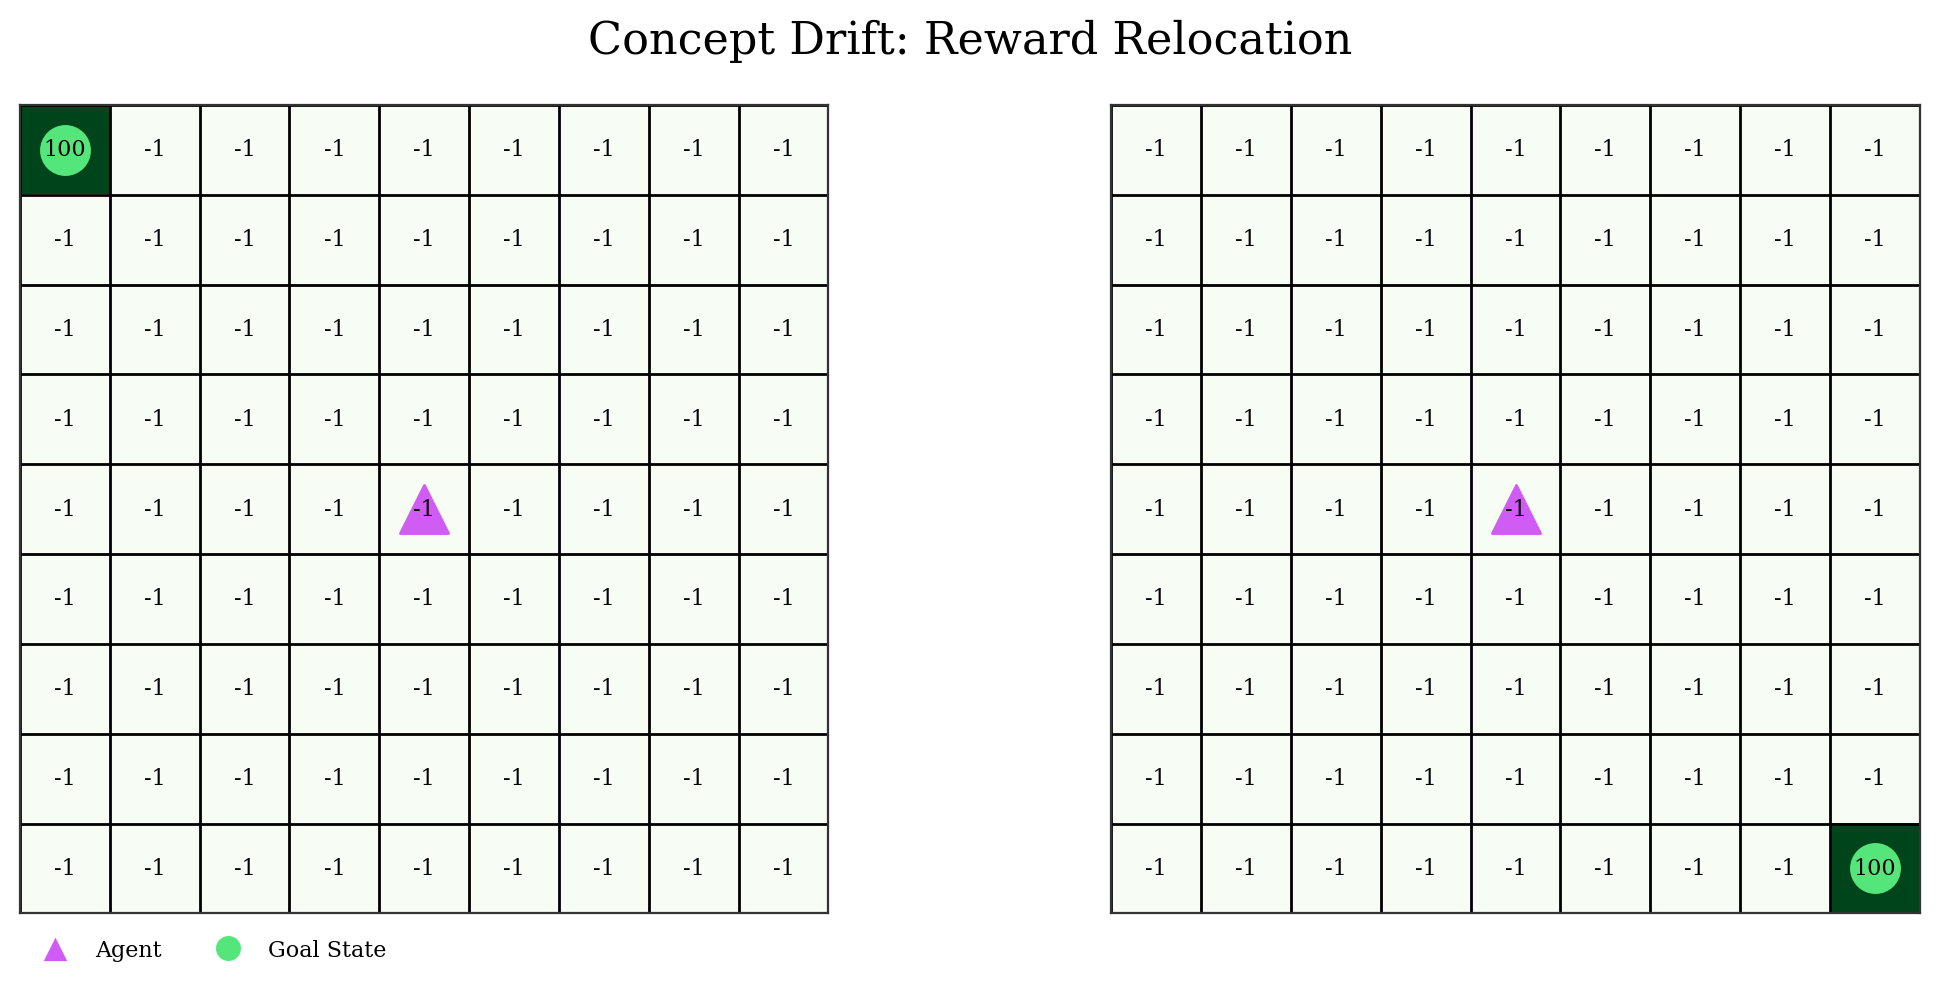

In [4]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Ejemplo de GRID_WORLD
N_ROWS, N_COLS = 9, 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1
GRID_WORLD[0, 0] = 100
GRID_WORLD[8, 8] = -1

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Primer subplot: configuración inicial
ax = axs[0]
im = ax.imshow(GRID_WORLD, cmap='Greens', interpolation='nearest')
for i in range(GRID_WORLD.shape[0]):
    for j in range(GRID_WORLD.shape[1]):
        ax.text(j, i, str(int(GRID_WORLD[i, j])), ha='center', va='center', color='black', fontsize=8)
ax.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax.scatter(0, 0, marker='o', color='#55e67b', s=300, label='Goal State')
#ax.set_title("Inicio")
ax.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='major', size=0)
ax.tick_params(which='minor', size=0)

# Segundo subplot: configuración modificada
GRID_WORLD[0, 0] = -1
GRID_WORLD[8, 8] = 100
ax2 = axs[1]
im2 = ax2.imshow(GRID_WORLD, cmap='Greens', interpolation='nearest')
for i in range(GRID_WORLD.shape[0]):
    for j in range(GRID_WORLD.shape[1]):
        ax2.text(j, i, str(int(GRID_WORLD[i, j])), ha='center', va='center', color='black', fontsize=8)
ax2.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax2.scatter(8, 8, marker='o', color='#55e67b', s=300, label='Goal State')
#ax2.set_title("Cambio de meta")
ax2.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax2.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax2.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax2.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(which='major', color='black', linestyle='-', linewidth=1)
ax2.tick_params(which='major', size=0)
ax2.tick_params(which='minor', size=0)

# Add legend for the agent (triangle) and the goal (circle) with correct shapes and smaller symbols

agent_legend = Line2D([0], [0], marker='^', color='w', label='Agent',
                      markerfacecolor='#d15bf5', markersize=10, linestyle='None')
goal_legend = Line2D([0], [0], marker='o', color='w', label='Goal State',
                     markerfacecolor='#55e67b', markersize=10, linestyle='None')
ax.legend(handles=[agent_legend, goal_legend], loc='lower left', fontsize=8, frameon=False, ncol=2, bbox_to_anchor=(.005, -.07), borderaxespad=0.)

plt.subplots_adjust(wspace=10)

plt.suptitle("Concept Drift: Reward Relocation", fontsize=16, y=.95)

plt.tight_layout()

plt.savefig('rewards_change.png', dpi=400, bbox_inches='tight')
plt.show()


Converged at episode 253:
Entrenamiento finalizado.


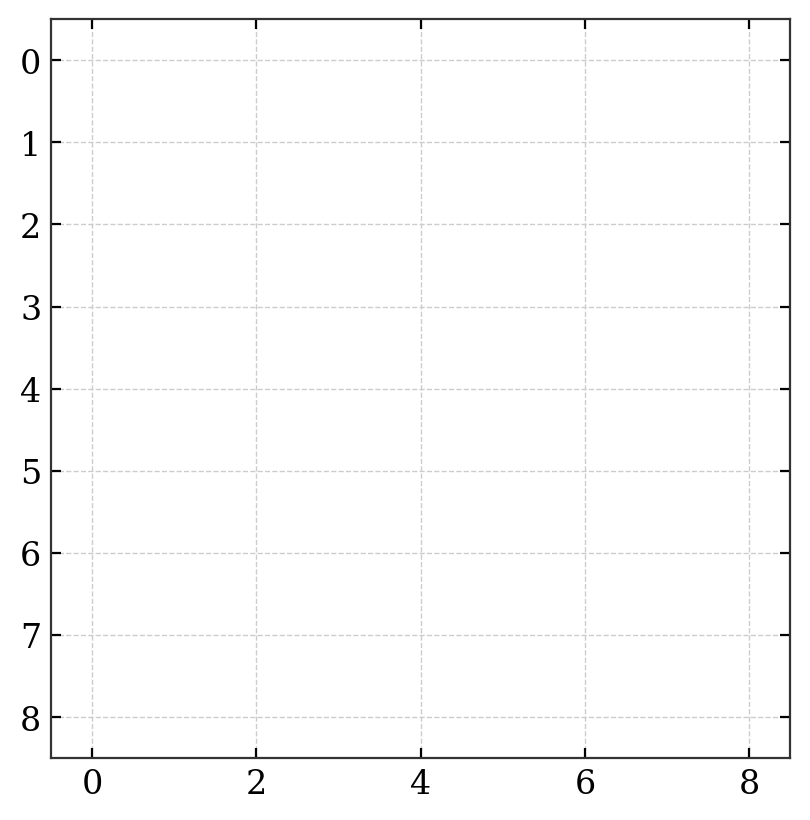

In [6]:
N_ROWS = 9
N_COLS = 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1

# Definición de los estados meta
GOAL_STATE_1 = (0, 0)
GOAL_STATE_2 = (8, 8)
GRID_WORLD[GOAL_STATE_1] = 100  # Objetivo inicial
GRID_WORLD[GOAL_STATE_2] = -1  # Penalización inicial

EXPLOTATION = 0.2

# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 4),
    actions=['Up', 'Down', 'Left', 'Right'],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=0.001,
    alpha=0.1,      # Tasa base baja para preservar conocimiento cuando el error es pequeño
    alpha_max=0.99,  # Tasa alta para cambios bruscos
    td_threshold=5,
)

learning_curve = []
exploration_curve = []
step_changes = []
episode_to_step = {}
alpha_evol = []
episode = 0
ite = 0  # Contador total de iteraciones
e = 0

# Para este ejemplo, modificaremos el entorno en episodios específicos
episode_changes = [300, 600, 900, 1200]

q_learning_acc = 0

first_qtable = agent.q_knowledge.copy()
stage_block = [0, 300, 600, 900, 1200 ,1500, 1600]
converged_episodes = []
converged_i = 0

ims = []
fig, ax = plt.subplots()


while episode < 1500:
    epsilon = agent.epsilon_decay(step=e)
    action = agent.choose_action(epsilon)
    initial_state = agent.current_state
    next_state = agent.get_next_state(initial_state, action)
    reward = GRID_WORLD[next_state]
    
    new_q = agent.move(reward, action)
    q_learning_acc += new_q
    exploration_curve.append([epsilon, new_q])
    alpha_evol.append(agent.effective_alpha)
    
    ite += 1
    e += 1
    
    # Finalizar episodio si se alcanza un objetivo o se excede un límite de pasos
    if (GRID_WORLD[next_state]==100) or (agent.steps > (N_COLS + N_ROWS)*2):
        episode += 1
        agent.restart()
        learning_curve.append(q_learning_acc / ite)
        
        # Cuando se alcanza un episodio en el que se planea un cambio, se modifica el entorno
        # (Opcional) Si en episodios específicos se desea cambiar el entorno:
        if episode in episode_changes:
            # Alterna el objetivo cambiando la recompensa en el grid
            if episode in [300, 900, 1500]:
                GRID_WORLD[GOAL_STATE_1] = -1
                GRID_WORLD[GOAL_STATE_2] = 100
            else:
                GRID_WORLD[GOAL_STATE_1] = 100
                GRID_WORLD[GOAL_STATE_2] = -1
            step_changes.append(ite)
            episode_to_step[episode] = ite 
            
        # Identify if the agent already converged
        if episode > 1:
            # Use stage_block to determine current stage boundaries
            if converged_i < len(stage_block) - 1:
                prev_change = stage_block[converged_i]
                next_change = stage_block[converged_i + 1]
            else:
                prev_change = stage_block[-2]
                next_change = stage_block[-1]
            # Check if Q-table has converged before the next environment change
            if (np.max(np.abs(agent.q_knowledge - first_qtable)) < 0.01) and (prev_change < episode < next_change):
                converged_episodes.append(episode)
                converged_i += 1
                print(f"Converged at episode {episode}:")
            else:
                first_qtable = agent.q_knowledge.copy()
            
            
    if ite % 100 == 0:
        im = ax.imshow(np.max(agent.q_knowledge, axis=0), animated=True)
        color_goal_1 = 'green' if GRID_WORLD[GOAL_STATE_1] == 100 else 'red'
        color_goal_2 = 'red' if color_goal_1 == 'green' else 'green'
        scatter_goal_1 = ax.scatter(GOAL_STATE_1[1], GOAL_STATE_1[0], color=color_goal_1, s=100, animated=True)
        scatter_goal_2 = ax.scatter(GOAL_STATE_2[1], GOAL_STATE_2[0], color=color_goal_2, s=100, animated=True)

        ims.append([im, scatter_goal_1, scatter_goal_2])
        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

            
print("Entrenamiento finalizado.")

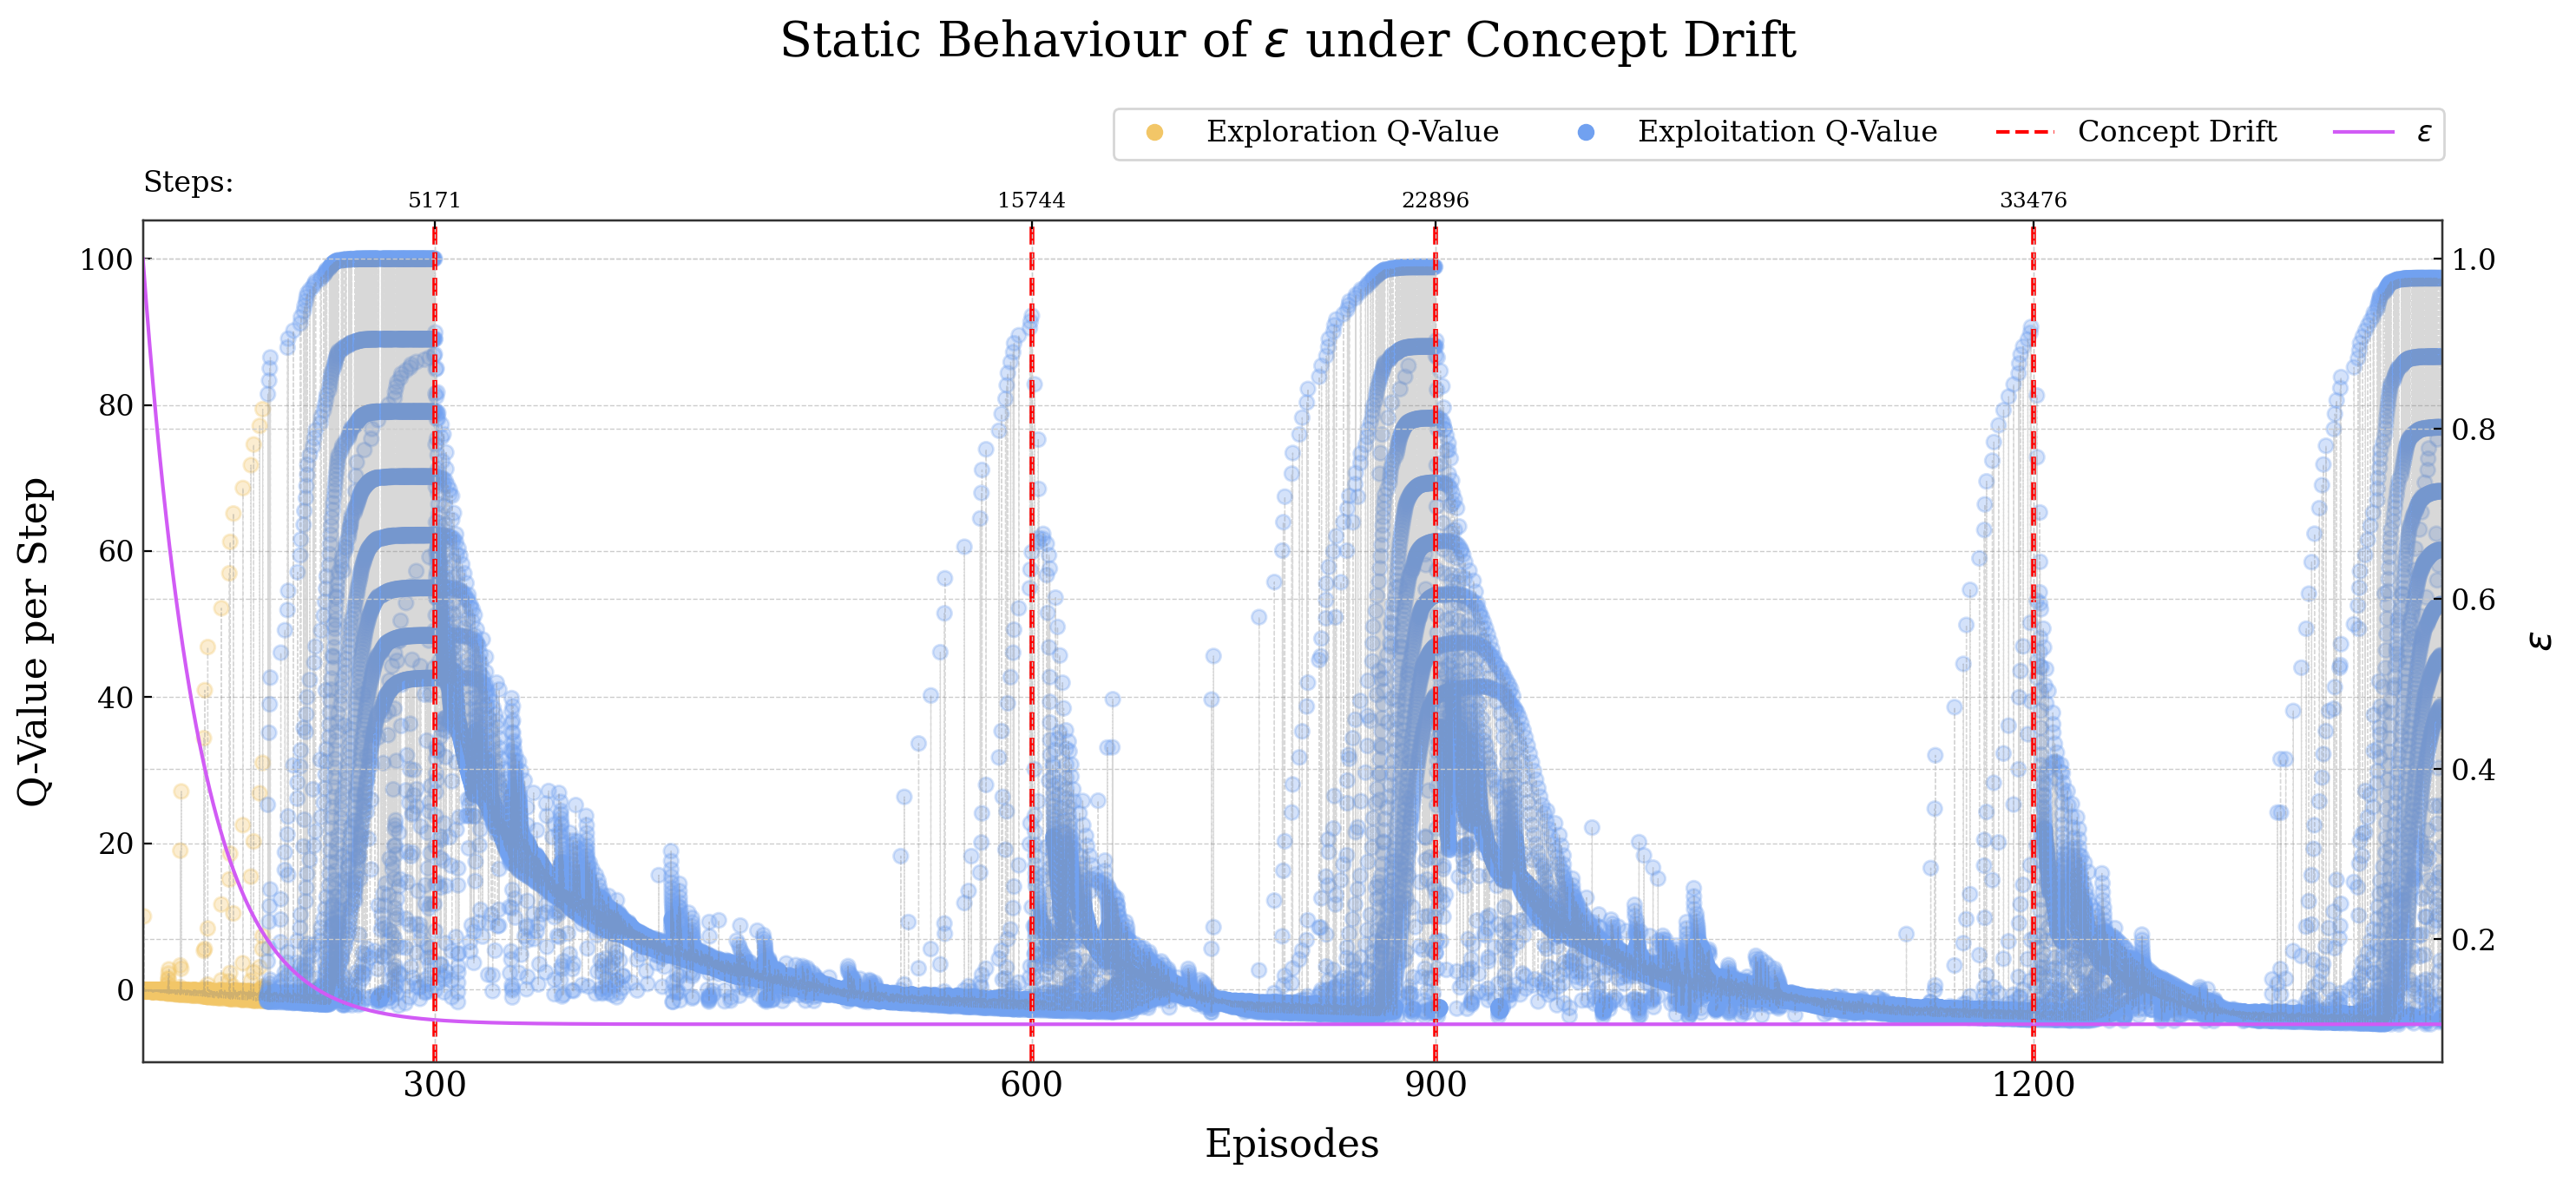

In [11]:
eps, q_val = zip(*exploration_curve)
total_steps = len(eps)
episode_to_step = dict(zip(episode_changes, step_changes))

fig, ax = plt.subplots(figsize=(15, 7))

# 1) Q-values vs pasos en eje principal (ax)
ax.plot(range(total_steps), q_val, c='gray', alpha=0.3, linestyle='--', linewidth=0.5, zorder=20)
ax.scatter(
    range(total_steps), q_val,
    c=['#71a1f0' if e < EXPLOTATION else '#f2c667' for e in eps],
    ec=['#71a1f0' if e < EXPLOTATION else '#f2c667' for e in eps],
    zorder=10, alpha=0.3
)
ax.set_ylabel('Q-Value per Step', fontsize=16, labelpad=10)
ax.set_xlabel('Episodes', fontsize=16, labelpad=10)

# 2) Epsilon vs pasos en eje secundario (ax2)
ax2 = ax.twinx()
ln_eps, = ax2.plot(range(total_steps), eps, c='#d15bf5', label=r'$\varepsilon$', zorder=30)
#ax2.axhline(0.1, color='#18a15e', linestyle='-')
ax2.set_ylabel('$\\varepsilon$', fontsize=16, labelpad=10)

# 3) Concept drifts (líneas verticales rojas)
for ep, st in episode_to_step.items():
    ax.axvline(x=st, color='red', linestyle='--', linewidth=2,
               zorder=5e5)

# 4) Remapeo de ticks inferiores: posiciones = steps, etiquetas = episodes
step_ticks    = [episode_to_step[e] for e in episode_changes]
episode_ticks = episode_changes
ax.set_xticks(step_ticks)
ax.set_xticklabels(episode_ticks, fontsize=14)
ax.set_xlim(0, total_steps)

# 5) Eje superior: mismo rango, pero etiquetas = steps
ax_top = ax.twiny()                        # crea eje x superior
ax_top.set_xlim(ax.get_xlim())             # igualamos los límites de ambos ejes
ax_top.set_xticks(step_ticks)              # ubicamos las mismas posiciones
ax_top.set_xticklabels(step_ticks, fontsize=9)         # mostramos los valores de step
ax_top.set_xlabel('Steps:', fontsize=12, labelpad=0, loc='left')

# 6) Leyenda y título
expl_sc   = mpl.lines.Line2D([], [], marker='o', color='#f2c667',
                             linestyle='None', markersize=6, label='Exploration Q-Value')
explo_sc  = mpl.lines.Line2D([], [], marker='o', color='#71a1f0',
                             linestyle='None', markersize=6, label='Exploitation Q-Value')
change_sc = mpl.lines.Line2D([], [], color='red', linestyle='--', label='Concept Drift')
leg = ax.legend(handles=[expl_sc, explo_sc, change_sc, ln_eps],
                ncol=4, loc='upper right', frameon=True, bbox_to_anchor=(1.007, 1.15),
                )

plt.suptitle('Static Behaviour of $\\varepsilon$ under Concept Drift', fontsize=20, y=.97)

plt.tight_layout()

plt.savefig('trad_eps.png', dpi=400, bbox_inches='tight')

plt.show()


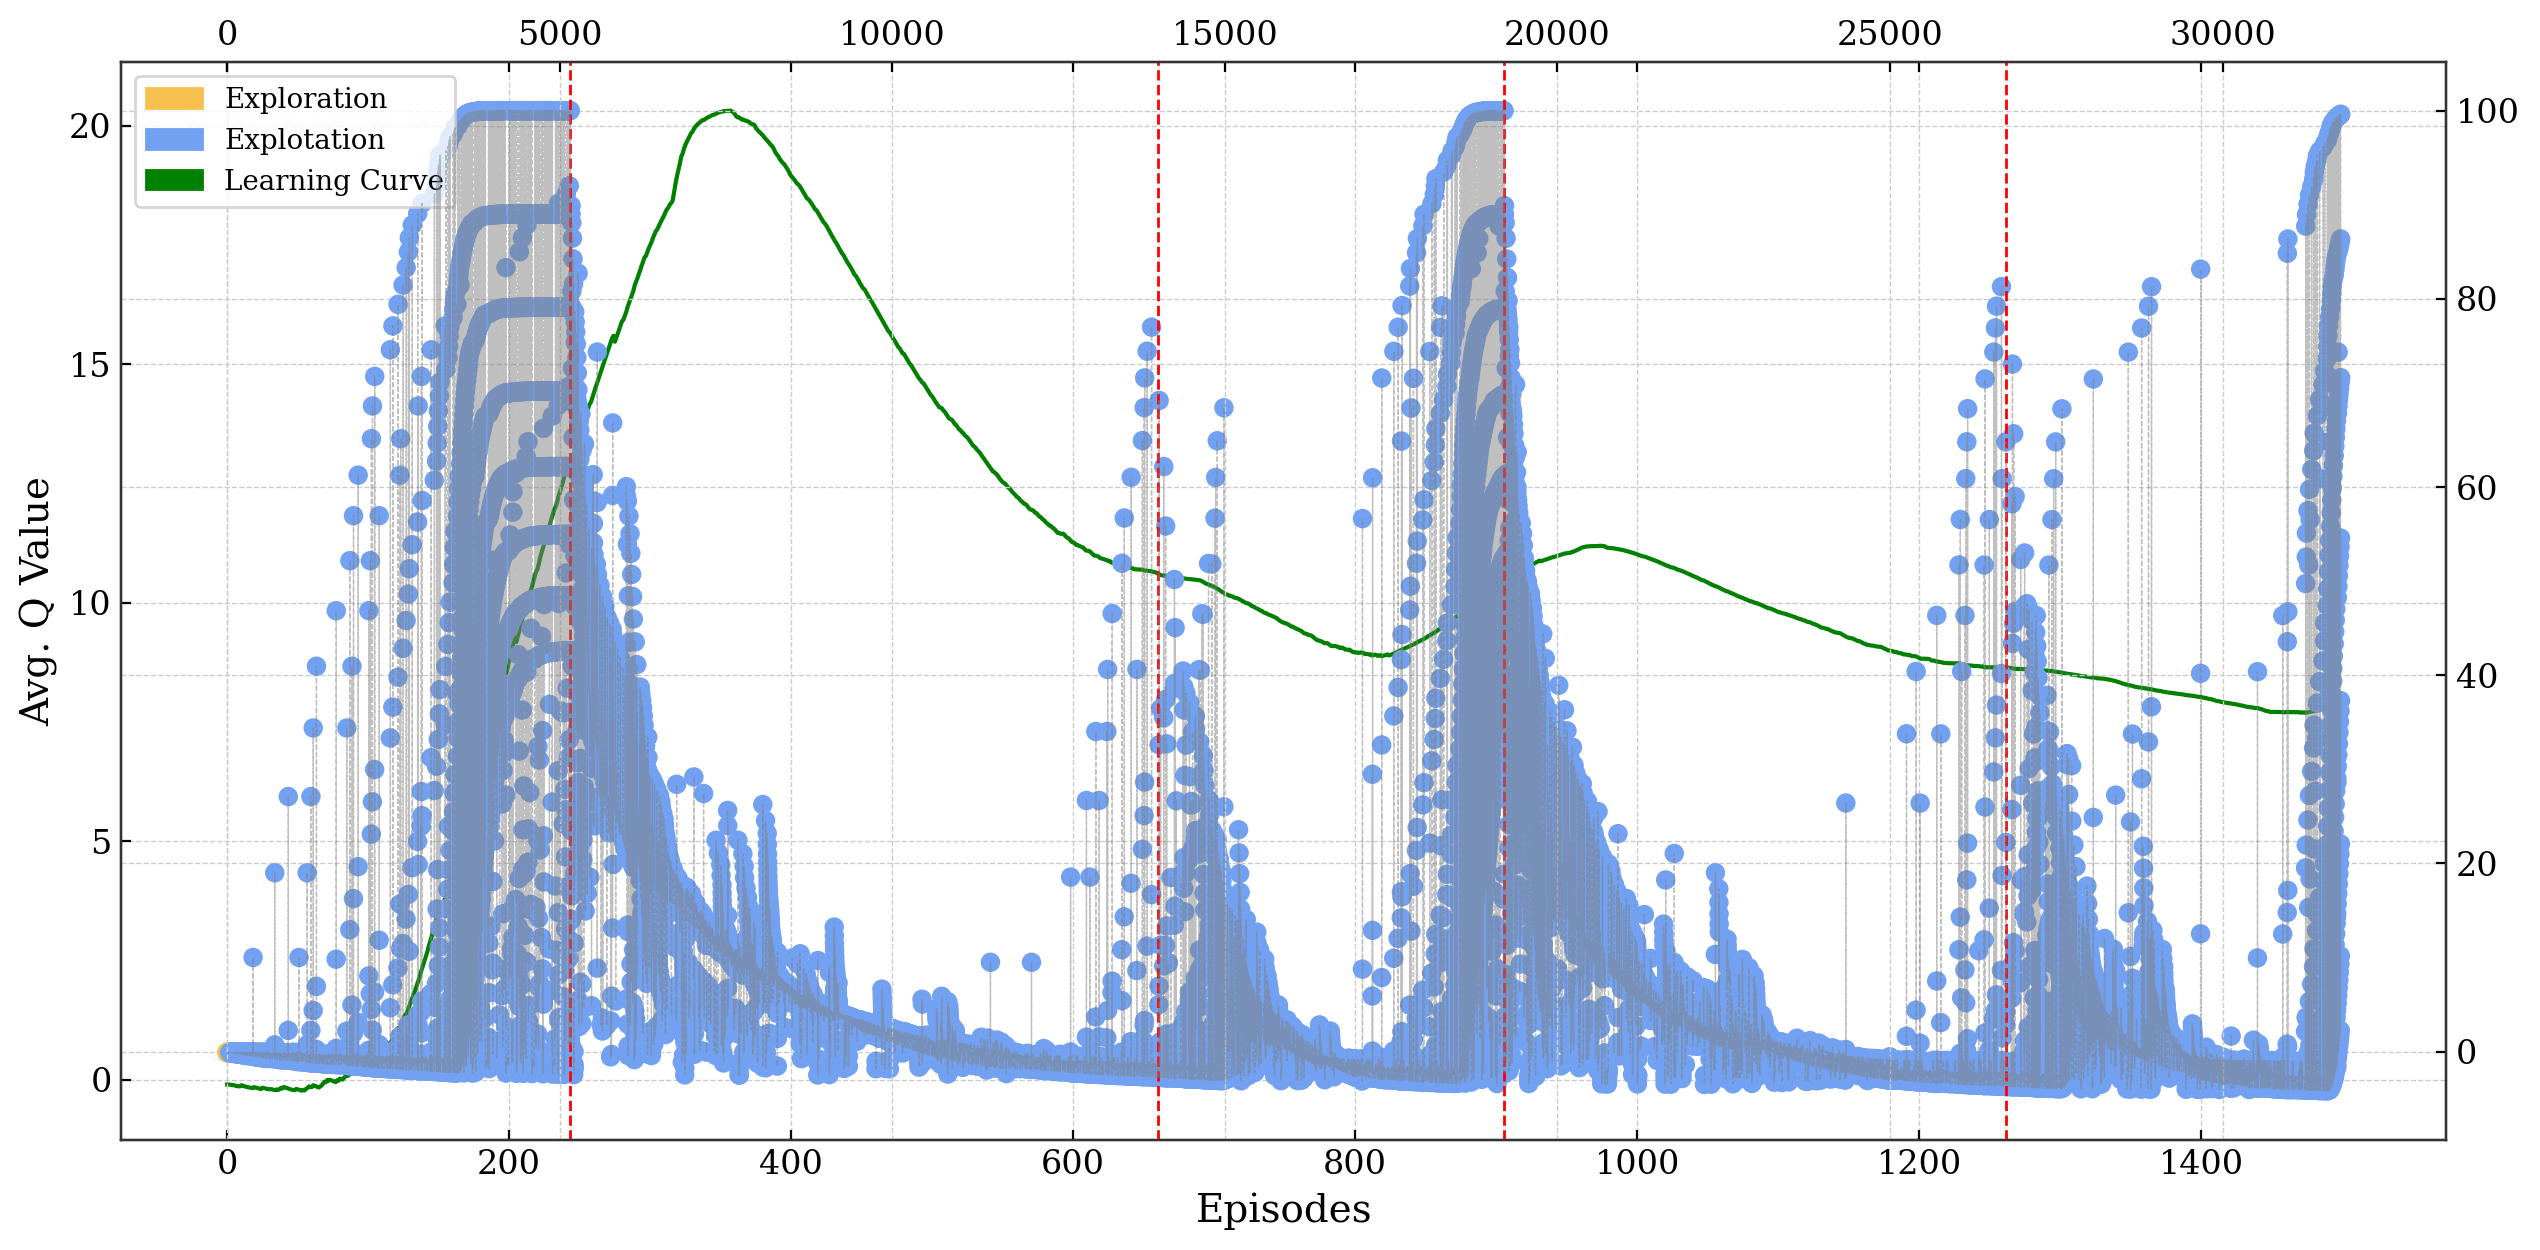

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(learning_curve, c='green', zorder=1000, label='Learning Curve')
plt.ylabel('Avg. Q Value')
plt.xlabel('Episodes')
#plt.legend()

    
plt.twinx()
plt.twiny()
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5, zorder=10)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f2c667'for e in eps], zorder=1)
plt.ylabel('Q Value')
for change in step_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f2c667', label='Exploration')
green_line = mpatches.Patch(color='green', label='Learning Curve')
plt.legend(handles=[orange_patch, blue_patch, green_line], loc='upper left', fontsize=10)


plt.show()

In [30]:
POLICY_MAP = np.zeros((N_ROWS, N_COLS))
LABEL_MAP = np.empty((N_ROWS, N_COLS), dtype=object)

for row in range(N_ROWS):
    for col in range(N_COLS):
        action, value = agent.get_best_action((row, col))
        POLICY_MAP[row, col] = value
        LABEL_MAP[row, col] = f'{action}\n{value:.2f}'

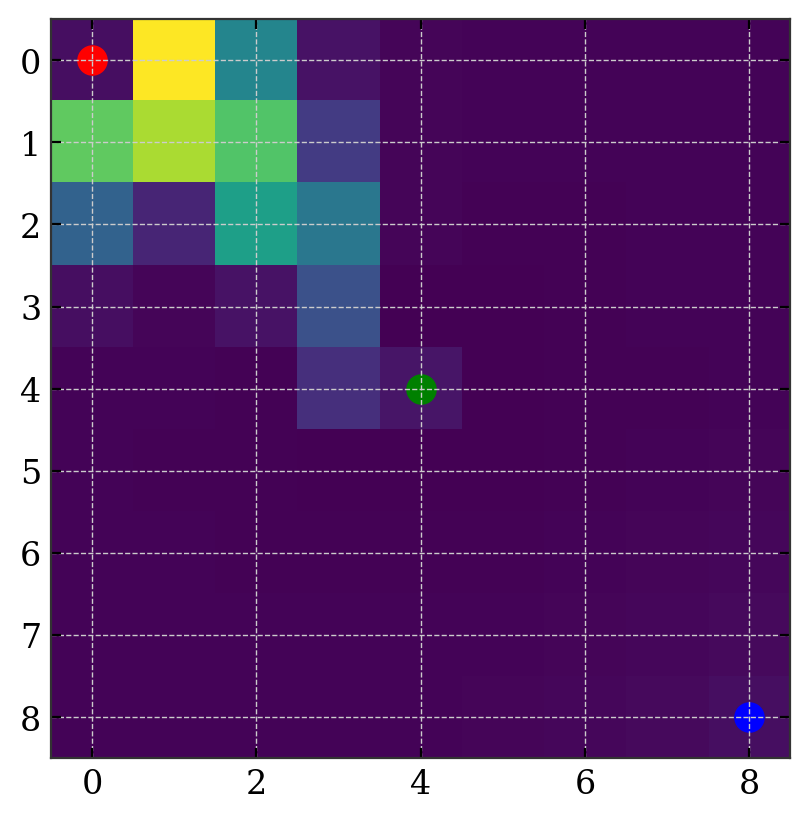

In [31]:
plt.imshow(POLICY_MAP, cmap='viridis', interpolation='nearest')
plt.scatter(*GOAL_STATE_1[::-1], c='red', s=100, label='Goal 1')
plt.scatter(*GOAL_STATE_2[::-1], c='blue', s=100, label='Goal 2')
plt.scatter(*agent.initial_state[::-1], c='green', s=100, label='Start')

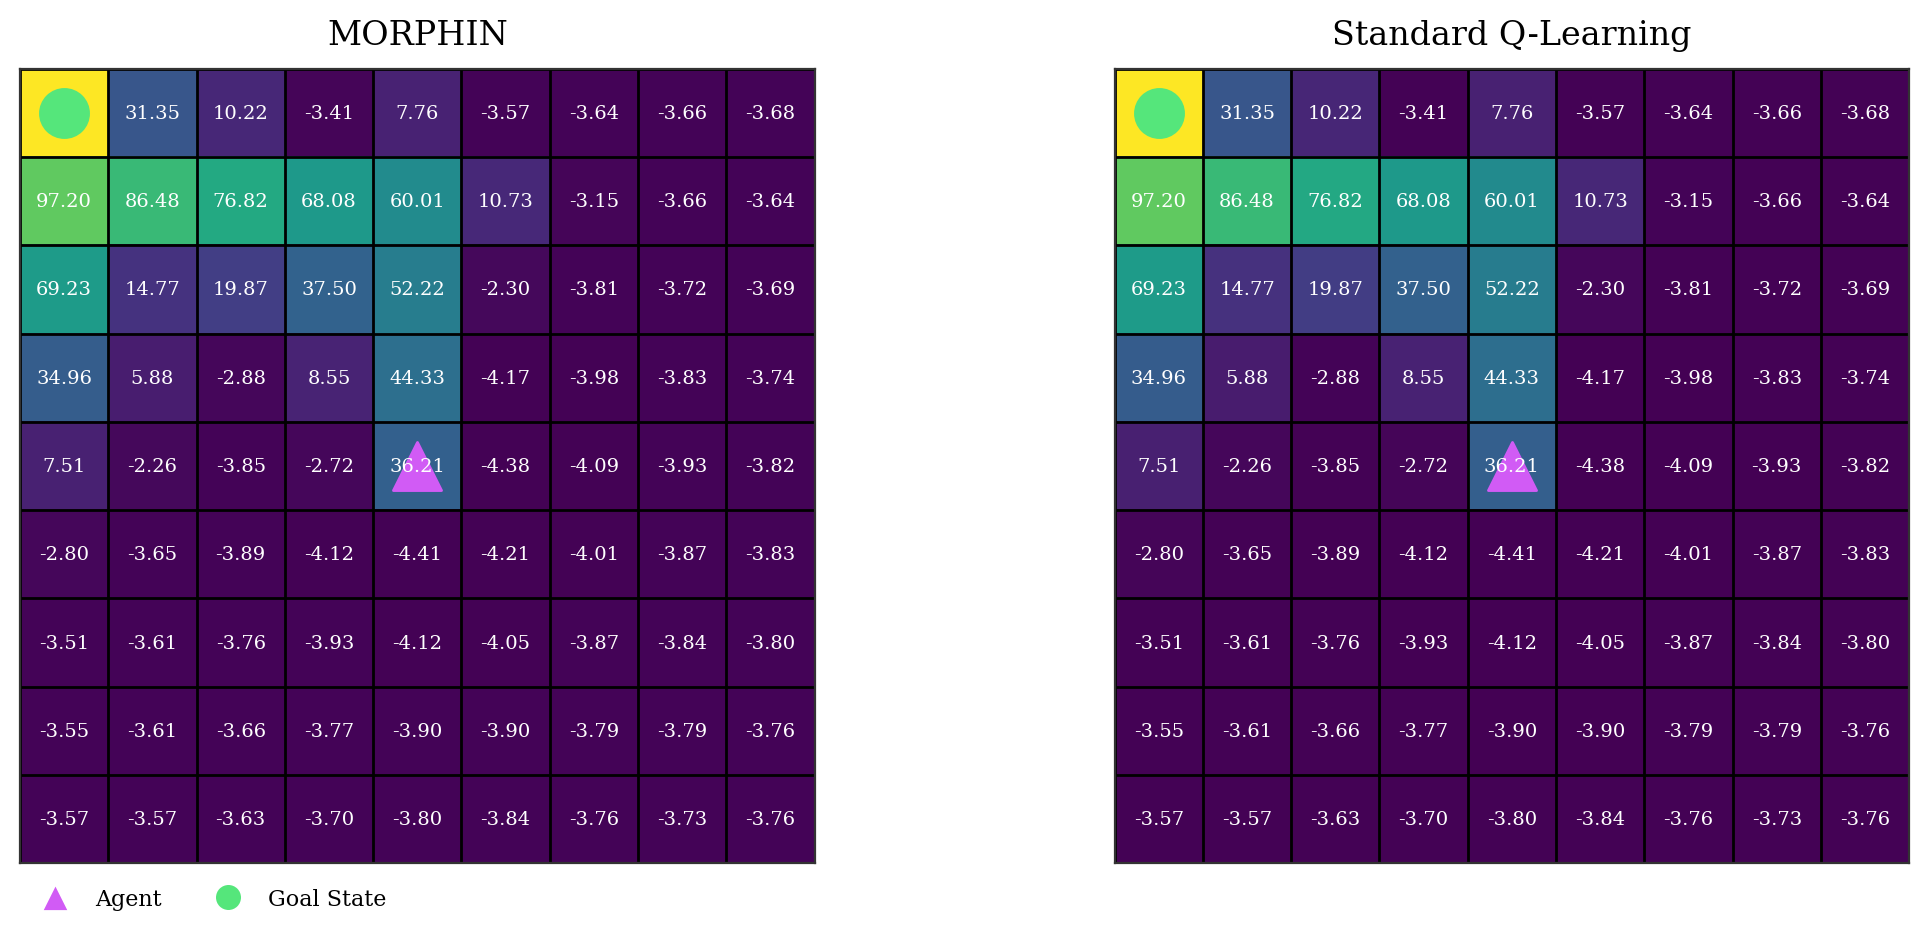

In [7]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Ejemplo de GRID_WORLD
N_ROWS, N_COLS = 9, 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1
GRID_WORLD[0, 0] = 100
GRID_WORLD[8, 8] = -1

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

solution = np.max(agent.q_knowledge, axis=0)
solution[0,0] = 130

# Primer subplot: configuración inicial
ax = axs[0]
im = ax.imshow(solution, cmap='viridis', interpolation='nearest', vmin=-5)
for i in range(solution.shape[0]):
    for j in range(solution.shape[1]):
        if (i,j)==(0,0):
            continue
        ax.text(j, i, f"{solution[i, j]:.2f}", ha='center', va='center', color='w', fontsize=7)
ax.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax.scatter(0, 0, marker='o', color='#55e67b', s=300, label='Goal State')
#ax.set_title("Inicio")
ax.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='major', size=0)
ax.tick_params(which='minor', size=0)

# Segundo subplot: configuración modificada
GRID_WORLD[0, 0] = -1
GRID_WORLD[8, 8] = 100
ax2 = axs[1]
im2 = ax2.imshow(solution, cmap='viridis', interpolation='nearest')
for i in range(GRID_WORLD.shape[0]):
    for j in range(GRID_WORLD.shape[1]):
        if (i,j)==(0,0):
            continue
        ax2.text(j, i, f"{solution[i, j]:.2f}", ha='center', va='center', color='w', fontsize=7)
ax2.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax2.scatter(0, 0, marker='o', color='#55e67b', s=300, label='Goal State')
#ax2.set_title("Cambio de meta")
ax2.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax2.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax2.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax2.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(which='major', color='black', linestyle='-', linewidth=1)
ax2.tick_params(which='major', size=0)
ax2.tick_params(which='minor', size=0)
#set title to ax2



# Add legend for the agent (triangle) and the goal (circle) with correct shapes and smaller symbols

agent_legend = Line2D([0], [0], marker='^', color='w', label='Agent',
                      markerfacecolor='#d15bf5', markersize=10, linestyle='None')
goal_legend = Line2D([0], [0], marker='o', color='w', label='Goal State',
                     markerfacecolor='#55e67b', markersize=10, linestyle='None')
ax.legend(handles=[agent_legend, goal_legend], loc='lower left', fontsize=8, frameon=False, ncol=2, bbox_to_anchor=(.005, -.07), borderaxespad=0.)

plt.subplots_adjust(wspace=10)

#plt.suptitle("Q-Value Heatmaps after 1,500 Episodes in a Non-Stationary Reward Environment", fontsize=16, y=1.01)
ax2.set_title("Standard Q-Learning", fontsize=12, y=1.01)
ax.set_title("MORPHIN", fontsize=12, y=1.01)

plt.tight_layout()

plt.savefig('q_table_comp_2.png', dpi=400, bbox_inches='tight')
plt.show()


In [32]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

In [33]:
ani.save("../simulations/memory_stm_v1.mp4")

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '3000x1400', '-pix_fmt', 'rgba', '-framerate', '20.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../simulations/memory_stm_v1.mp4']' returned non-zero exit status 255.

### Multiple repetitions

In [154]:
len(exploration_curve)

39517

In [4]:
## Run 100 times the complete agent training to get the average of convergence
convergence_simulations = []
total_steps = []

for _ in tqdm(range(1000)):
    
    N_ROWS = 9
    N_COLS = 9
    GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1

    # Definición de los estados meta
    GOAL_STATE_1 = (0, 0)
    GOAL_STATE_2 = (8, 8)
    GRID_WORLD[GOAL_STATE_1] = 100  # Objetivo inicial
    GRID_WORLD[GOAL_STATE_2] = -1  # Penalización inicial

    EXPLOTATION = 0.2

    # Inicialización del agente
    agent = AdaptativeAgent(
        initial_state=(4, 4),
        actions=['Up', 'Down', 'Left', 'Right'],
        n_rows=N_ROWS,
        n_cols=N_COLS,
        decay_rate=0.05,
        alpha=0.1,      # Tasa base baja para preservar conocimiento cuando el error es pequeño
        alpha_max=0.99,  # Tasa alta para cambios bruscos
        td_threshold=5,
    )

    learning_curve = []
    exploration_curve = []
    step_changes = []
    episode_to_step = {}
    alpha_evol = []
    episode = 0
    ite = 0  # Contador total de iteraciones
    e = 0

    # Para este ejemplo, modificaremos el entorno en episodios específicos
    episode_changes = [300, 600, 900, 1200]

    q_learning_acc = 0

    first_qtable = agent.q_knowledge.copy()
    stage_block = [0, 300, 600, 900, 1200 ,1500, 1600]
    converged_episodes = []
    converged_i = 0

    while episode < 1500:
        epsilon = agent.epsilon_decay(step=e)
        action = agent.choose_action(epsilon)
        initial_state = agent.current_state
        next_state = agent.get_next_state(initial_state, action)
        reward = GRID_WORLD[next_state]
        
        new_q = agent.move(reward, action)
        q_learning_acc += new_q
        exploration_curve.append([epsilon, new_q])
        alpha_evol.append(agent.effective_alpha)
        
        ite += 1
        e += 1
        
        # Finalizar episodio si se alcanza un objetivo o se excede un límite de pasos
        if (GRID_WORLD[next_state]==100) or (agent.steps > (N_COLS + N_ROWS) * 2):
            episode += 1
            agent.restart()
            learning_curve.append(q_learning_acc / ite)
            
            # Cuando se alcanza un episodio en el que se planea un cambio, se modifica el entorno
            # (Opcional) Si en episodios específicos se desea cambiar el entorno:
            if episode in episode_changes:
                # Alterna el objetivo cambiando la recompensa en el grid
                if episode in [300, 900, 1500]:
                    GRID_WORLD[GOAL_STATE_1] = -1
                    GRID_WORLD[GOAL_STATE_2] = 100
                else:
                    GRID_WORLD[GOAL_STATE_1] = 100
                    GRID_WORLD[GOAL_STATE_2] = -1
                step_changes.append(ite)
                episode_to_step[episode] = ite 
                
            # Identify if the agent already converged
            if episode > 1:
                # Use stage_block to determine current stage boundaries
                if converged_i < len(stage_block) - 1:
                    prev_change = stage_block[converged_i]
                    next_change = stage_block[converged_i + 1]
                else:
                    prev_change = stage_block[-2]
                    next_change = stage_block[-1]
                # Check if Q-table has converged before the next environment change
                if (np.max(np.abs(agent.q_knowledge - first_qtable)) < 0.01) and (prev_change < episode < next_change):
                    converged_episodes.append(episode)
                    converged_i += 1
                else:
                    first_qtable = agent.q_knowledge.copy()
                    
    convergence_simulations.append(converged_episodes)
    total_steps.append(len(exploration_curve))

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


In [5]:
from scipy import stats

In [6]:
morphin_total_steps = [23913,
 23897,
 21756,
 23154,
 24781,
 24059,
 23325,
 22403,
 23412,
 26232,
 24004,
 24827,
 23742,
 24171,
 23371,
 21365,
 22025,
 25032,
 21714,
 21467,
 23738,
 22614,
 26447,
 22855,
 24359,
 23851,
 21772,
 25501,
 24242,
 24468,
 22113,
 24907,
 22470,
 23874,
 26358,
 22932,
 24517,
 22729,
 23629,
 23359,
 25161,
 25517,
 21973,
 23009,
 24602,
 26145,
 22964,
 20521,
 23877,
 22903,
 25137,
 23398,
 23352,
 24220,
 23729,
 24687,
 22835,
 24139,
 22737,
 21106,
 24394,
 24525,
 23028,
 22052,
 23949,
 23274,
 22715,
 21202,
 20936,
 24332,
 21291,
 23859,
 23283,
 22826,
 24984,
 25055,
 23274,
 27162,
 24347,
 22662,
 24964,
 20993,
 23657,
 25553,
 23334,
 25380,
 24564,
 22538,
 24542,
 22607,
 23578,
 23878,
 24675,
 21776,
 21178,
 22113,
 22330,
 22134,
 25226,
 22649,
 25021,
 22911,
 20909,
 22336,
 21443,
 21688,
 23875,
 23559,
 21766,
 22412,
 22435,
 25575,
 24527,
 25950,
 25538,
 23271,
 23319,
 21699,
 21403,
 22739,
 24153,
 22263,
 24469,
 26096,
 23343,
 23455,
 24617,
 27402,
 24178,
 22715,
 25932,
 21361,
 21824,
 21888,
 25974,
 23662,
 25516,
 23520,
 23599,
 25772,
 23416,
 22973,
 23083,
 22223,
 23207,
 25389,
 22262,
 28205,
 23898,
 23710,
 24109,
 21854,
 26150,
 23113,
 24042,
 22303,
 24780,
 21125,
 24364,
 21573,
 24496,
 21834,
 22824,
 21548,
 22452,
 22859,
 20563,
 25118,
 21532,
 24038,
 21735,
 23936,
 22783,
 22945,
 24142,
 25151,
 23624,
 21779,
 21768,
 22904,
 27931,
 22265,
 22577,
 26139,
 22020,
 21646,
 22540,
 23671,
 25155,
 20749,
 21372,
 24137,
 25459,
 24995,
 23075,
 23045,
 21098,
 24621,
 21428,
 22223,
 23059,
 22402,
 25401,
 23278,
 24069,
 24250,
 24351,
 23487,
 23283,
 23742,
 22054,
 26564,
 22955,
 24256,
 23310,
 26787,
 20302,
 21254,
 25379,
 25283,
 23939,
 26368,
 23128,
 22712,
 22613,
 23998,
 23672,
 23008,
 22090,
 25656,
 22296,
 23357,
 23547,
 21466,
 22988,
 21481,
 25109,
 23319,
 21946,
 21706,
 21107,
 23897,
 24630,
 26260,
 22411,
 23074,
 26149,
 20072,
 21587,
 24016,
 23150,
 22409,
 23579,
 24002,
 24135,
 21151,
 20790,
 24505,
 22243,
 22113,
 20182,
 22900,
 24035,
 25930,
 27281,
 24916,
 23863,
 24300,
 21596,
 24010,
 25168,
 23649,
 21710,
 24829,
 21801,
 24262,
 24700,
 23223,
 20416,
 25110,
 25471,
 22863,
 22302,
 21958,
 21451,
 24540,
 23071,
 22677,
 24578,
 23318,
 24709,
 24470,
 24881,
 23544,
 23846,
 20714,
 24454,
 21986,
 23141,
 23045,
 24452,
 22557,
 21698,
 24756,
 22191,
 24913,
 22112,
 23507,
 23687,
 21033,
 22275,
 21559,
 24726,
 22739,
 22154,
 21417,
 20934,
 21960,
 20785,
 22478,
 21310,
 21619,
 23126,
 23860,
 21194,
 25577,
 24244,
 23497,
 23650,
 23689,
 22530,
 23267,
 21949,
 23019,
 24971,
 23028,
 25722,
 20759,
 23423,
 21590,
 25666,
 23216,
 23615,
 21829,
 22974,
 27469,
 23369,
 24397,
 20675,
 22501,
 23711,
 23844,
 26234,
 24905,
 21105,
 22715,
 22114,
 24437,
 26291,
 23450,
 23346,
 23909,
 24636,
 22237,
 23665,
 22624,
 24273,
 24154,
 26579,
 22328,
 25385,
 23412,
 24682,
 22749,
 23298,
 22865,
 23699,
 21503,
 23300,
 24749,
 25637,
 22448,
 23902,
 24110,
 22787,
 25367,
 23090,
 23511,
 23073,
 22517,
 21640,
 23036,
 22985,
 23884,
 22736,
 22122,
 21779,
 23028,
 21654,
 22264,
 23028,
 24036,
 23200,
 25512,
 23804,
 25519,
 20882,
 21291,
 23411,
 21754,
 24705,
 22696,
 23716,
 22572,
 23901,
 22313,
 25211,
 26709,
 22165,
 21735,
 22216,
 24888,
 23235,
 21791,
 25302,
 24880,
 24392,
 23082,
 25776,
 22860,
 23809,
 20002,
 21101,
 22079,
 25351,
 22855,
 25954,
 24552,
 24422,
 21546,
 23946,
 23447,
 22404,
 23765,
 22679,
 23857,
 21358,
 21965,
 24142,
 24197,
 22540,
 23419,
 22916,
 22301,
 21870,
 22220,
 21554,
 26355,
 21417,
 23339,
 21973,
 23899,
 22950,
 21429,
 22253,
 22047,
 25894,
 25216,
 26205,
 25272,
 20652,
 26290,
 23973,
 25821,
 23090,
 23851,
 25649,
 23225,
 23761,
 22305,
 21506,
 24134,
 23573,
 23552,
 23796,
 22658,
 23292,
 22347,
 21492,
 22412,
 23172,
 19350,
 23885,
 20967,
 24152,
 23104,
 24160,
 22193,
 24023,
 25860,
 23014,
 22161,
 24606,
 22756,
 21953,
 21029,
 23974,
 22311,
 22534,
 23062,
 21132,
 23168,
 22912,
 23571,
 20436,
 25766,
 24008,
 25167,
 23384,
 23100,
 22909,
 24052,
 25078,
 23214,
 22776,
 21348,
 22726,
 23916,
 23893,
 20637,
 23039,
 23998,
 22554,
 23926,
 25459,
 23612,
 21720,
 22230,
 24983,
 22212,
 22946,
 22005,
 25086,
 23443,
 26115,
 21007,
 22729,
 23059,
 23553,
 25778,
 23639,
 21287,
 24199,
 21953,
 23486,
 21394,
 22403,
 23963,
 23994,
 24306,
 24416,
 23560,
 22571,
 23627,
 24095,
 24701,
 24689,
 24338,
 22346,
 22159,
 21803,
 23212,
 21267,
 22008,
 22589,
 22950,
 22623,
 22524,
 24240,
 24731,
 23297,
 23428,
 23812,
 24406,
 24024,
 22095,
 22879,
 22254,
 21124,
 22765,
 25466,
 21020,
 22014,
 24314,
 25987,
 23581,
 24673,
 20270,
 25280,
 22947,
 22043,
 21552,
 22442,
 24094,
 23941,
 25251,
 22007,
 23056,
 23972,
 22352,
 23967,
 22195,
 26171,
 22740,
 23076,
 23742,
 23497,
 23601,
 23685,
 25444,
 24102,
 23130,
 24223,
 24712,
 27380,
 20782,
 22464,
 23911,
 26640,
 30866,
 20135,
 24077,
 23017,
 24221,
 21440,
 24358,
 23802,
 24476,
 24435,
 25975,
 25237,
 23144,
 23074,
 21569,
 24042,
 25684,
 24238,
 23285,
 21527,
 23807,
 21823,
 25252,
 22379,
 25106,
 25569,
 23771,
 25184,
 23530,
 20623,
 22773,
 20960,
 20741,
 24091,
 24135,
 24078,
 23741,
 23077,
 21834,
 23571,
 24115,
 22769,
 21800,
 24219,
 19842,
 22714,
 24172,
 21811,
 22040,
 21053,
 21216,
 25293,
 22866,
 23582,
 24914,
 23341,
 22090,
 24612,
 21557,
 22096,
 23185,
 23181,
 24822,
 23252,
 22544,
 23458,
 23937,
 22487,
 24534,
 22859,
 21258,
 22325,
 23738,
 22862,
 22682,
 21413,
 23032,
 25201,
 23332,
 22978,
 23517,
 24056,
 21850,
 22897,
 27172,
 22426,
 21790,
 22772,
 24210,
 21839,
 24664,
 22869,
 23505,
 22055,
 23923,
 23847,
 26053,
 23336,
 24820,
 22235,
 20718,
 25366,
 22095,
 24748,
 22188,
 23652,
 22838,
 25181,
 24165,
 27072,
 23967,
 23364,
 21601,
 24350,
 21534,
 24551,
 21654,
 22260,
 22903,
 23116,
 21613,
 23498,
 23084,
 21353,
 23095,
 26496,
 22151,
 22563,
 21766,
 23965,
 22216,
 22286,
 23547,
 24679,
 23994,
 22254,
 22324,
 23385,
 22876,
 24044,
 23009,
 23514,
 24122,
 21955,
 22170,
 23910,
 22827,
 23397,
 23818,
 23619,
 21389,
 21958,
 22810,
 27934,
 21449,
 24167,
 25346,
 25494,
 22557,
 23020,
 25033,
 22895,
 24764,
 24007,
 24833,
 22481,
 24101,
 23326,
 22289,
 21162,
 23142,
 22708,
 22865,
 22869,
 23372,
 25012,
 23900,
 24070,
 21574,
 22387,
 21980,
 22535,
 25895,
 23418,
 23174,
 24272,
 21791,
 20229,
 20930,
 20865,
 22946,
 23827,
 22349,
 21240,
 22894,
 21378,
 23309,
 25163,
 23144,
 21273,
 28458,
 21492,
 22988,
 21304,
 24216,
 22660,
 23337,
 23536,
 25347,
 21020,
 21350,
 24465,
 21338,
 22591,
 23202,
 23963,
 24970,
 22306,
 26051,
 23956,
 23722,
 22666,
 25533,
 23404,
 23527,
 23389,
 25074,
 24807,
 22096,
 22274,
 23657,
 22891,
 24840,
 23179,
 23200,
 23008,
 20140,
 22625,
 22462,
 25489,
 23608,
 22617,
 23371,
 22769,
 24284,
 21661,
 25138,
 21166,
 23359,
 25170,
 21641,
 25130,
 23583,
 25396,
 22247,
 25383,
 23917,
 22194,
 24700,
 23303,
 22851,
 22653,
 24706,
 23129,
 22830,
 22068,
 24440,
 24779,
 23483,
 25277,
 24212,
 24093,
 24222,
 22073,
 22887,
 22506,
 25356,
 24221,
 24153,
 20813,
 23548,
 25715,
 24042,
 22173,
 24056,
 25040,
 23396,
 24071,
 24499,
 24619,
 25202,
 26780,
 21190,
 23368,
 21243,
 21831,
 23444,
 22894,
 21073,
 23337,
 23395,
 23935,
 22224,
 20097,
 22431,
 24302,
 23623,
 23924,
 26869,
 23106,
 24193,
 24538,
 22467,
 21816,
 21403,
 24467,
 22264,
 24394,
 23243,
 21684,
 23155,
 22121,
 23009,
 21698,
 23166,
 23477,
 22469,
 23687,
 23273,
 23883,
 21905,
 23816,
 23790,
 25127,
 24883,
 22259,
 22996,
 22197,
 25579,
 24621,
 22239,
 24050,
 22596,
 22359,
 23129,
 21212,
 19969,
 22532,
 23015,
 23272,
 22134,
 24272,
 22158,
 25576,
 22954,
 23288,
 22752,
 26281,
 23544,
 25286,
 23013,
 21531,
 21118,
 23470,
 24086,
 23987,
 24559,
 22803,
 23820,
 24462,
 23221]

In [8]:
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(morphin_total_steps, total_steps)

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.10f}")

# Interpret the results
alpha = 0.05
print(f"\nSignificance level (alpha) = {alpha}")
if p_value < alpha:
    print("Conclusion: The difference is statistically significant.")
    print("We reject the null hypothesis; the adaptive mechanism has a significant effect on the agent's efficiency.")
else:
    print("Conclusion: The difference is not statistically significant.")
    print("We fail to reject the null hypothesis.")


T-statistic: -350.1579
P-value: 0.0000000000

Significance level (alpha) = 0.05
Conclusion: The difference is statistically significant.
We reject the null hypothesis; the adaptive mechanism has a significant effect on the agent's efficiency.


In [164]:
np.mean(total_steps), np.std(total_steps)
# calculate the incertidumbre of the total_steps in porcentage
mean_steps = np.mean(total_steps)
std_steps = np.std(total_steps)
incert = (std_steps / mean_steps) * 100
print(f"Mean steps: {mean_steps:.2f} ± {std_steps:.2f} ({incert:.2f}%)")

Mean steps: 40683.74 ± 539.44 (1.33%)


In [168]:
mean_convergence = np.mean([i[0] for i in convergence_simulations if i])
std_convergence = np.std([i[0] for i in convergence_simulations if i])
incert_convergence = (std_convergence / mean_convergence) * 100
print(f"Mean convergence: {mean_convergence:.2f} ± {std_convergence:.2f} ({incert_convergence:.2f}%)")

Mean convergence: 256.40 ± 11.15 (4.35%)


In [169]:
sum(True if len(i) == 1 else False for i in convergence_simulations), len(convergence_simulations)

(999, 1000)

In [170]:
999/1000 * 100

99.9